我写的第一版代码来自<<集体智慧编程>>,代码不多,主要是通过计算两个向量之间的pearson距离来确定两个向量的相似度,然后用k均值的方法来实现聚类,代码迭代的次数有点多,数据也有点多,所以跑得比较慢,下面是代码部分:

In [ ]:
import pymssql
import random
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

def conn_db(server="127.0.0.1", user="sa", pwd="123", db="moveState"):
    """用于连接数据库"""
    return pymssql.connect(server, user, pwd, db)

def pearson(v1, v2):
    """计算两个向量的pearson距离"""
    assert(len(v1) == len(v2)) # 两个向量的长度应该是一致的
    n = len(v1)
    sum1 = sum(v1)
    sum2 = sum(v2)
    # print("sum1 = %d, sum2 = %d" % (sum1, sum2))

    # 求平方和
    sum1Sq = sum([pow(v, 2) for v in v1])
    sum2Sq = sum([pow(v, 2) for v in v2])

    # 求乘积之和
    pSum = sum([v1[i] * v2[i] for i in range(n)])

    # 计算距离
    num = pSum - (sum1 * sum2 / n)
    den = sqrt((sum1Sq - pow(sum1, 2) / n) * (sum2Sq - pow(sum2, 2) / n))
    if den == 0:
        return 1
    return num / den

# print(pearson([1, 2, 3, 4], [1, 2, 3, 5]))

# 接下来要使用迭代器获得数据
def get_next_vec(conn):
    """获得数据向量"""
    def clean_data(item):
        if item == None:
            return 0
        else:
            return item
    cursor = conn.cursor()
    cursor.execute("select * from MoveState03")
    row = cursor.fetchone()
    while row:
        # 在这里,我们要对数据进行一定程度的清理,具体是将NULL变为0
        yield (row[0], list(map(clean_data, row[1:])))
        row = cursor.fetchone()

def kcluster(rows, distance=pearson, k=10):
    """k均值聚类"""
    # 随机创建k个中心点
    # random.random()返回一个在[0.0, 1.0)之间的伪随机数
    n = len(rows[0]) # 向量的长度
    clusters = [[random.random() for i in range(n)] for j in range(k)]

    lastmatches = None
    for t in range(15): # 最多迭代100次
        print('Iteration %d' % t)
        bestmatches = [[] for i in range(k)]
        # 在每一行中寻找距离最近的中心点
        for j in range(len(rows)):
            row = rows[j]
            bestmatch = 0
            for i in range(k):
                d = distance(clusters[i], row)
                if d < distance(clusters[bestmatch], row): bestmatch = i
            bestmatches[bestmatch].append(j) # 将行的行号加入
        # 如果结果与上一次相同,则整个过程结束
        if bestmatches == lastmatches: break
        lastmatches = bestmatches
        # 将中心点移到其所有成员的平均位置
        for i in range(k):
            avgs = [0.0] * n
            if len(bestmatches[i]) > 0:
                for rowid in bestmatches[i]:
                    for m in range(n): #
                        avgs[m] += rows[rowid][m] # 将rows[rowid]对应位置的

                for j in range(n): # 其实就是求一下平均值
                    avgs[j] /= len(bestmatches[i])
                clusters[i] = avgs
    return bestmatches

if __name__ == '__main__':
    conn = conn_db()
    count = 0
    rows = {}
    # 获取1000辆车的数据
    size = 1000
    for item in get_next_vec(conn):
        id, vec = item
        rows[id] = vec
        #print(vec)
        count = count + 1
        if count >= size: break
    r = [v for x, v in rows.items()]
    print("%d car's data got!" %(size))
    bestmatch = kcluster(r)
    # 现在通过画图的方法来展示分类的效果
    index = 0
    x = []
    y = []
    for item in bestmatch:
        for each_x in item:
            x.append(each_x)
            y.append(index)
        index += 1
    X = np.array(x)
    Y = np.array(y)
    colors = np.random.rand(X.shape[0]) # 每个点的颜色都是随机生成的
    # area = area = np.pi * (5 * np.random.rand(x.shape[0]))**2 # 每个点面积的大小
    area = np.array([25] * X.shape[0])
    plt.scatter(X, Y, c = colors, s=area)
    plt.show()


    # i = 1
    # with open("res.txt", mode='w') as f:
    #     for group in bestmatch:
    #         print("group %02d: %s" %(i, group))
    #         f.write("group %02d:\n" % i)
    #         for index in group:
    #             f.write("%04d -> %s\n" %(index, r[index]))
    #         i = i + 1

    conn.close() # 关闭连接


上面的代码处理了1500辆车的数据,通过k均值聚类算法迭代了15次,生成了这样的一张图,横坐标代表每台车的标号,每台车都有唯一的一个标号,从0~1499,通过k均值聚类算法,指定聚成10个类,纵坐标代表类别,一共是个类别:
![图话1](fig_1.png)
下面的这张图是处理了1000辆车生成的分类图像:
![图画2](fig_2.png)
感觉分的类别有点多.

# 将运动状态和位置联系起来
接下来,我试图联系将车辆的运动状态和车辆的坐标联系起来,所以写了一下处理函数,下面是第一版本的函数,主要是对数据进行了一下清理和整理,代码下面也展示了输出的数据:

In [25]:
import pymssql

class coord:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __str__(self):
        return '%f,%f' %(self.x, self.y)
# 一种更好的做法是,将数据库的连接和释放封装在一个类里面
class db:
    def __init__(self):
        self.conn = self.conn_db()
    def conn_db(self, server="127.0.0.1", user="sa", pwd="123", db="moveState"):
        """用于连接数据库"""
        return pymssql.connect(server, user, pwd, db)
    def __del__(self):
        self.conn.close()
        print('Connection is closed!')
    # 接下来要使用迭代器获得数据
    def get_next_vec(self):
        """获得数据向量"""
        prev_value = -1
        def clean_data(item):
            global prev_value
            if item == None:
                return 0
            elif item == -1:
                return prev_value
            else:
                prev_value = item
                return item
        cur = self.conn.cursor()
        cur.execute("select * from MoveState03 as m, MoveStateCoordinate03 as mc "
                     "where m.vehicle_id = mc.vehicle_id")
        rows = cur.fetchone()
        while rows:
            # 在这里,我们要对数据进行一定程度的清理,具体是将NULL变为0
            cln_data = list(map(clean_data, rows))
            # 得到状态,已经地址的信息
            yield (cln_data[0],  [(cln_data[i], cln_data[i + 745]) for i in range(1, 745)])
            rows = cur.fetchone()


In [21]:
k = data.get_next_vec()
next(k)

(100663297,
 [(0, 28191113006),
  (0, 28213113003),
  (0, 28213113003),
  (0, 28213113003),
  (0, 28213113003),
  (0, 28213113003),
  (0, 28213113003),
  (0, 28213113003),
  (0, 28213113003),
  (1, 28213113003),
  (0, 28213113003),
  (1, 28213113003),
  (1, 28007112983),
  (0, 28007112983),
  (0, 28007112983),
  (1, 28212113014),
  (0, 28211113003),
  (0, 28211113004),
  (0, 28186113005),
  (0, 28186113005),
  (1, 28189113003),
  (1, 28187112980),
  (0, 28185112997),
  (0, 28185112997),
  (0, 28191113006),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28190113004),
  (0, 28

上面的版本的处理还不够精细,所以我又写了下面一个版本的处理函数,下面的版本相对于上面的版本做了很大的改进,同时,为了更加直观地查看车辆的位置,我将车辆的坐标在坐标上标注了出来,下面输出的是一个小小的例子:

In [1]:
%matplotlib inline
import pymssql
import numpy as np
import matplotlib.pyplot as plt

class coord:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __str__(self):
        return '%.3f,%.3f' %(self.x, self.y)
    def getx(self):
        return self.x
    def gety(self):
        return self.y

# 一种更好的做法是,将数据库的连接和释放封装在一个类里面
class db:
    def __init__(self):
        self.conn = self.conn_db()
    def conn_db(self, server="127.0.0.1", user="sa", pwd="123", db="moveState"):
        """用于连接数据库"""
        return pymssql.connect(server, user, pwd, db)
    def __del__(self):
        self.conn.close()
        print('Connection is closed!')
    # 接下来要使用迭代器获得数据
    def get_next_vec(self):
        """获得数据向量"""
        def clean_state(item):
            '''用于清理空缺的状态值'''
            if item == None:
                return 0
            else:
                return item
        def clean_coord_closure(origin):
            '''构建一个闭包'''
            
            def get_coord(item):
                '''将int类型的坐标信息转换成坐标'''
                # 取高5位
                x = (float)(item // 1000000) / 1000
                # 取低6位
                y = (float)(item % 1000000) / 1000
                return coord(x, y)

            prev_value = get_coord(origin)
            
            def clean_coord(item):
                '''用于解析出坐标值'''
                nonlocal prev_value
                if item == -1: # 车辆静止
                    return prev_value
                elif item == 1: # 车辆在运动之中
                    return coord(0.0, 0.0)
                else:
                    prev_value = get_coord(item)
                    return prev_value
            return clean_coord
        
        def get_first_not_one(data):
            '''获得data中第一个不是1或者-1的数据'''
            for i in data:
                if i != 1 and i != -1: return i

        cur = self.conn.cursor()
        cur.execute("select * from MoveState03 as m, MoveStateCoordinate03 as mc "
                     "where m.vehicle_id = mc.vehicle_id")
        rows = cur.fetchone()
        while rows:
            # 在这里,我们要对数据进行一定程度的清理
            states = list(map(clean_state, rows[1:745]))
            temp_rows = rows[746:]
            positions = list(map(clean_coord_closure(get_first_not_one(temp_rows)), temp_rows))
            # 得到状态,已经地址的信息
            yield (rows[0],  [(states[i], positions[i]) for i in range(len(states))])
            rows = cur.fetchone()

if __name__ == '__main__':
    data = db()
    i = 0
    for item in data.get_next_vec():
        a, b = item
        # print(a)
        #for record in b:
        #    print("%d %s" %(record[0], record[1]))
        x = np.array([item[1].getx() for item in b])
        y = np.array([item[1].gety() for item in b])
        i = i + 1
        colors = np.random.rand(x.shape[0]) # 每个点的颜色都是随机生成的
        area = area = np.pi * (5 * np.random.rand(x.shape[0]))**2 # 每个点面积的大小
        plt.scatter(x, y,s=area, c=colors, alpha=0.9) # alpha指的是透明度
        if i > 0:
            break
        # x = np.array([item[1].getx() for item in b])
        # y = np.array([item[1].gety() for item in b])
        # plt.scatter(x, y)
        # print(x)
        # print(y)
        # i = i + 1
        # if i > 1:
        #    break


下面这张图是通过抽取出一辆车744小时的地点信息绘制成的,横坐标代表经度,纵坐标代表纬度.可以看到,大部分时间里,车辆在一块不大的区域里活动,但是偶尔也会到达很远的地方.
![图画3](fig_3.png)

但是我暂时还看不到地点信息和车辆的类别有什么联系.

## 聚类算法的测试
然后在找资料的过程中,发现了很有名的scikit-learn的机器学习包,里面已经实现了很多的聚类算法,我索性尝试用它的聚类算法来跑数据,首先进行测试的依然是k均值聚类.值得一提的是,算法运行速度非常快,我们先看一下原来的测试结果:

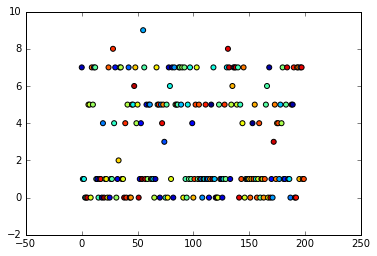

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import pymssql


def conn_db(server="127.0.0.1", user="sa", pwd="123", db="moveState"):
    """用于连接数据库"""
    return pymssql.connect(server, user, pwd, db)

# 接下来要使用迭代器获得数据
def get_next_vec(conn):
    """获得数据向量"""
    def clean_data(item):
        if item == None:
            return 0
        else:
            return item
    cursor = conn.cursor()
    cursor.execute("select * from MoveState03")
    row = cursor.fetchone()
    while row:
        # 在这里,我们要对数据进行一定程度的清理,具体是将NULL变为0
        yield (row[0], list(map(clean_data, row[1:])))
        row = cursor.fetchone()

if __name__ == '__main__':
    conn = conn_db()
    count = 0
    rows = {}
    # 获取200辆车的数据
    size = 200
    for item in get_next_vec(conn):
        id, vec = item
        rows[id] = vec
        #print(vec)
        count = count + 1
        if count >= size: break
    r = [v for x, v in rows.items()]
    data = np.array(r)
    res = KMeans(n_clusters=10, max_iter=900).fit(data)
    x = np.linspace(0, size - 1, size)
    colors = np.random.rand(x.shape[0]) # 每个点的颜色都是随机生成的
    # area = area = np.pi * (5 * np.random.rand(x.shape[0]))**2 # 每个点面积的大小
    area = np.array([25] * x.shape[0])
    plt.scatter(x, res.labels_, c = colors, s=area)

下面是600辆车被分成了10个类的聚类效果:

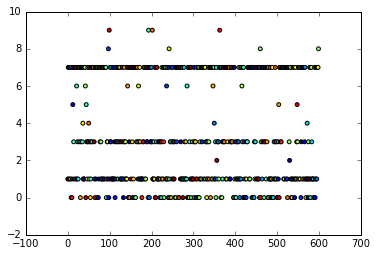

In [5]:
if __name__ == '__main__':
    conn = conn_db()
    count = 0
    rows = {}
    # 获取200辆车的数据
    size = 600
    for item in get_next_vec(conn):
        id, vec = item
        rows[id] = vec
        count = count + 1
        if count >= size: break
    r = [v for x, v in rows.items()]
    data = np.array(r)
    res = KMeans(n_clusters=10, max_iter=900).fit(data)
    x = np.linspace(0, size-1, size)
    colors = np.random.rand(x.shape[0]) # 每个点的颜色都是随机生成的
    area = np.array([15] * x.shape[0])
    plt.scatter(x, res.labels_, c = colors, s=area)

然后是2000辆车的聚类效果,貌似车辆越多,分类效果就一般了:

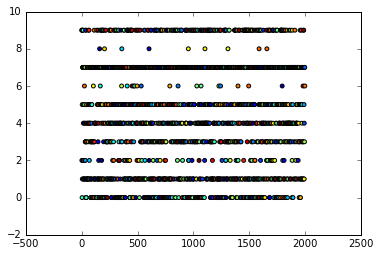

In [7]:
if __name__ == '__main__':
    conn = conn_db()
    count = 0
    rows = {}
    # 获取1000辆车的数据
    size = 2000
    for item in get_next_vec(conn):
        id, vec = item
        rows[id] = vec
        #print(vec)
        count = count + 1
        if count >= size: break
    r = [v for x, v in rows.items()]
    data = np.array(r)
    res = KMeans(n_clusters=10, max_iter=900).fit(data)
    x = np.linspace(0, size-1, size)
    colors = np.random.rand(x.shape[0]) # 每个点的颜色都是随机生成的
    # area = area = np.pi * (5 * np.random.rand(x.shape[0]))**2 # 每个点面积的大小
    area = np.array([15] * x.shape[0])
    plt.scatter(x, res.labels_, c = colors, s=area)

## AP聚类
接下来我要换另外的一种算法来聚类,下面是采用AP聚类生成的效果:

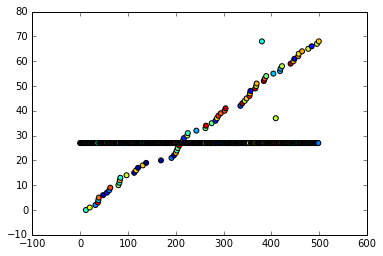

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AffinityPropagation
import pymssql


def conn_db(server="127.0.0.1", user="sa", pwd="123", db="moveState"):
    """用于连接数据库"""
    return pymssql.connect(server, user, pwd, db)

# 接下来要使用迭代器获得数据
def get_next_vec(conn):
    """获得数据向量"""
    def clean_data(item):
        if item == None:
            return 0
        else:
            return item
    cursor = conn.cursor()
    cursor.execute("select * from MoveState03")
    row = cursor.fetchone()
    while row:
        # 在这里,我们要对数据进行一定程度的清理,具体是将NULL变为0
        yield (row[0], list(map(clean_data, row[1:])))
        row = cursor.fetchone()

if __name__ == '__main__':
    conn = conn_db()
    count = 0
    rows = {}
    # 获取500辆车的数据
    size = 500
    for item in get_next_vec(conn):
        id, vec = item
        rows[id] = vec
        count = count + 1
        if count >= size: break
    r = [v for x, v in rows.items()]
    data = np.array(r)
    res = AffinityPropagation(max_iter=900).fit(data)
    x = np.linspace(0, size-1, size)
    colors = np.random.rand(x.shape[0]) # 每个点的颜色都是随机生成的
    area = np.array([25] * x.shape[0])
    plt.scatter(x, res.labels_, c = colors, s=area)

这种算法分出来的类别非常多,特别是当数据量大了的时候,效果就不太理想了.

## SpectralClustering聚类
采用`SpectralClustering`聚类产生的效果如下:

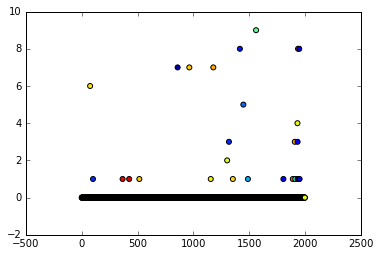

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering
import pymssql


def conn_db(server="127.0.0.1", user="sa", pwd="123", db="moveState"):
    """用于连接数据库"""
    return pymssql.connect(server, user, pwd, db)

# 接下来要使用迭代器获得数据
def get_next_vec(conn):
    """获得数据向量"""
    def clean_data(item):
        if item == None:
            return 0
        else:
            return item
    cursor = conn.cursor()
    cursor.execute("select * from MoveState03")
    row = cursor.fetchone()
    while row:
        # 在这里,我们要对数据进行一定程度的清理,具体是将NULL变为0
        yield (row[0], list(map(clean_data, row[1:])))
        row = cursor.fetchone()

if __name__ == '__main__':
    conn = conn_db()
    count = 0
    rows = {}
    # 获取2000辆车的数据
    size = 2000
    for item in get_next_vec(conn):
        id, vec = item
        rows[id] = vec
        #print(vec)
        count = count + 1
        if count >= size: break
    r = [v for x, v in rows.items()]
    data = np.array(r)
    res = SpectralClustering(n_clusters=10).fit(data)
    x = np.linspace(0, size-1, size)
    colors = np.random.rand(x.shape[0]) # 每个点的颜色都是随机生成的
    # area = area = np.pi * (5 * np.random.rand(x.shape[0]))**2 # 每个点面积的大小
    area = np.array([25] * x.shape[0])
    plt.scatter(x, res.labels_, c = colors, s=area)